# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from urllib.request import urlopen

# Import and clean tables

## Wikipedia episode data

In [2]:
html_1 = urlopen('https://en.wikipedia.org/wiki/List_of_The_Simpsons_episodes_(seasons_1-20)')
bs_1 = BeautifulSoup(html_1.read(),'html.parser')

html_2 = urlopen('https://en.wikipedia.org/wiki/List_of_The_Simpsons_episodes')
bs_2 = BeautifulSoup(html_2.read(),'html.parser')

In [3]:
episode_tables = bs_1.find_all('table',{'class':"wikitable plainrowheaders wikiepisodetable"})
episodes = [pd.read_html(str(i))[0] for i in episode_tables if 'The Simpsons Movie' not in str(i)]

episode_tables = bs_2.find_all('table',{'class':"wikitable plainrowheaders wikiepisodetable"})
episodes.extend([pd.read_html(str(i))[0] for i in episode_tables if ('Screenplay by' not in str(i)) and ('Ratings/' not in str(i))])

for i in range(len(episodes)):
    episodes[i]['seasonNumber'] = i+1

episodes_df = pd.concat(episodes).reset_index(drop=True)

In [4]:
# fix problems with episodes 608,608

# old_ep = pd.DataFrame(episodes_df.iloc[607].copy()).transpose()
# old_ep[['No.overall','No. inseason','Prod.code']] = [608,12,'WABF04']

# new_ep = pd.DataFrame(episodes_df.iloc[607].copy()).transpose()
# new_ep[['No.overall','No. inseason','Prod.code']] = [609,13,'WABF05']

# episodes_df = pd.concat([episodes_df.iloc[:607],old_ep,new_ep,episodes_df.iloc[608:]]).reset_index(drop=True)

episodes_df.loc[607,['No.overall','No. inseason','Prod.code']]=[608,12,'WABF04']
episodes_df.loc[608:,'No.overall'] -= 1 
episodes_df.loc[608:616,'No. inseason'] -= 1 


# fix problems with 681, 682
old_ep = pd.DataFrame(episodes_df.iloc[679].copy()).transpose()
old_ep[['No.overall','No. inseason','Original air date','Prod.code','U.S. viewers(millions)']] = [680,19,'April 26, 2020','ZABF12','1.35']

new_ep = pd.DataFrame(episodes_df.iloc[679].copy()).transpose()
new_ep[['No.overall','No. inseason','Original air date','Prod.code','U.S. viewers(millions)']] = [681,20,'May 3, 2020','ZABF13','1.36']

episodes_df = pd.concat([episodes_df.iloc[:679],old_ep,new_ep,episodes_df.iloc[680:]]).reset_index(drop=True)

# convert ratings to numerical values
episodes_df['U.S. viewers(millions)'] = pd.to_numeric(episodes_df['U.S. viewers(millions)'].replace('\[.*\]','',regex=True))

#change column names
episodes_df.columns = ['overallNumber', 'episodeNumber', 'Title', 'Directed by', 'Written by',
       'Original air date', 'Prod.code', 'US_viewers_millions',
       'seasonNumber']

## IMDB ratings

In [5]:
imdb_episodes_df = pd.read_csv('./data/episode_data.txt',sep='\t')
imdb_episodes_df = imdb_episodes_df[imdb_episodes_df['parentTconst']=='tt0096697']
imdb_episodes_df['seasonNumber'] = pd.to_numeric(imdb_episodes_df['seasonNumber'])
imdb_episodes_df['episodeNumber'] = pd.to_numeric(imdb_episodes_df['episodeNumber'])
imdb_episodes_df = imdb_episodes_df.sort_values(['seasonNumber','episodeNumber']).reset_index(drop=True)

In [6]:
imdb_ratings_df = pd.read_csv('./data/rating_data.txt',sep='\t')
imdb_df = imdb_episodes_df.merge(imdb_ratings_df,on='tconst',how='inner')

In [7]:
simpsons_df = episodes_df.merge(imdb_df,on=['seasonNumber','episodeNumber'],how='inner')
simpsons_df

,overallNumber,episodeNumber,Title,Directed by,Written by,Original air date,Prod.code,US_viewers_millions,seasonNumber,tconst,parentTconst,averageRating,numVotes
0,1,1,"""Simpsons Roasting on an Open Fire""",David Silverman,Mimi Pond,"December 17, 1989",7G08,26.70,1,tt0348034,tt0096697,8.2,6326
1,2,2,"""Bart the Genius""",David Silverman,Jon Vitti,"January 14, 1990",7G02,24.50,1,tt0756593,tt0096697,7.7,4154
2,3,3,"""Homer's Odyssey""",Wesley Archer,Jay Kogen & Wallace Wolodarsky,"January 21, 1990",7G03,27.50,1,tt0701124,tt0096697,7.4,3664
3,4,4,"""There's No Disgrace Like Home""",Gregg Vanzo & Kent Butterworth,Al Jean & Mike Reiss,"January 28, 1990",7G04,20.20,1,tt0756399,tt0096697,7.7,3594
4,5,5,"""Bart the General""",David Silverman,John Swartzwelder,"February 4, 1990",7G05,27.10,1,tt0701059,tt0096697,8.0,3639
...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,701,18,"""Burger Kings""",Lance Kramer,Rob LaZebnik,"April 11, 2021",QABF11,1.24,32,tt13977692,tt0096697,6.8,277
701,702,19,"""Panic on the Streets of Springfield""",Matthew Nastuk,Tim Long,"April 18, 2021",QABF12,1.31,32,tt13977716,tt0096697,6.2,380
702,703,20,"""Mother and Child Reunion""",Jennifer Moeller,J. Stewart Burns,"May 9, 2021",QABF14,1.11,32,tt14056918,tt0096697,7.1,248
703,704,21,"""The Man from G.R.A.M.P.A.""",Mike Frank Polcino,Carolyn Omine,"May 16, 2021",QABF13,1.06,32,tt14056916,tt0096697,6.4,213


# EDA

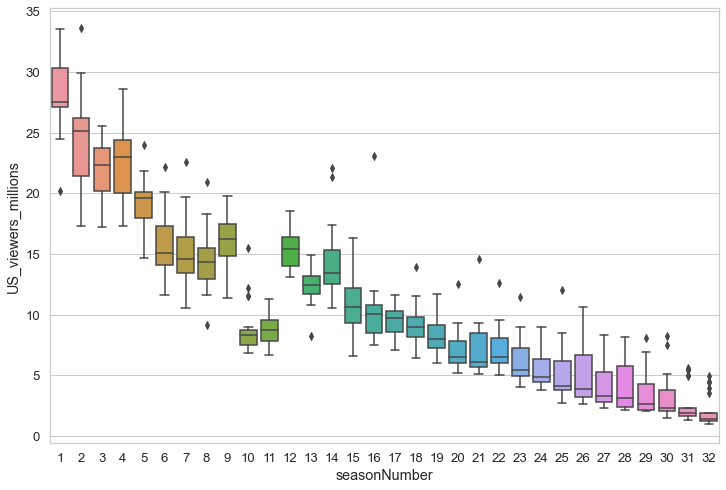

In [236]:
plt.figure(figsize=(12,8))
sns.set_theme(style='whitegrid',font_scale=1.2)
sns.boxplot(x='seasonNumber',y='US_viewers_millions',data=simpsons_df,)#s=2.2)
plt.show()

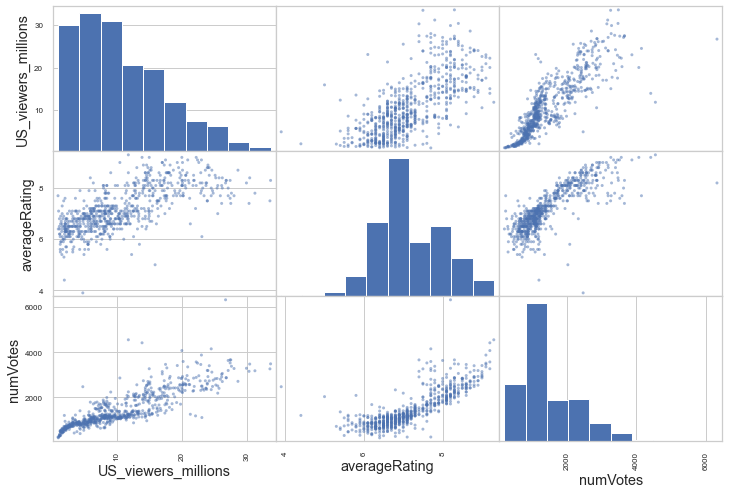

In [230]:
pd.plotting.scatter_matrix(simpsons_df,figsize=(12,8),diagonal='hist')
plt.show()

In [92]:
def plot_color_square(column,label=None):
    if label is None:
        label = column
    episodes_num = simpsons_df.groupby('seasonNumber').count()['episodeNumber'].to_numpy()
    episodes_max = np.max(episodes_num)
    seasons = 32

    square = np.empty([episodes_max,seasons])
    square[:]=np.nan
    
    for s in range(seasons):
        for e in range(episodes_num[s]):
            square[e,s] = simpsons_df[(simpsons_df['seasonNumber']==s+1) & (simpsons_df['episodeNumber']==e+1)][column]


    plt.figure(figsize=(15,15))
    plt.grid(b=True,which='both',alpha=0.3)
    plt.minorticks_on()
    cmap = mpl.cm.get_cmap("RdYlGn").copy()
    cmap.set_bad("white")
    plt.pcolormesh(square,cmap=cmap,edgecolors='k',vmin=np.quantile(simpsons_df[column].dropna(),0.01),vmax=np.quantile(simpsons_df[column].dropna(),0.99))
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(0.5,32.5))
    ax.set_xticklabels(range(1,33))
    ax.set_yticks(np.arange(0.5,25.5))
    ax.set_yticklabels(range(1,26))
    plt.colorbar(shrink=0.5).set_label(label)
    plt.ylabel('Episode number')
    plt.xlabel('Season')
    plt.title(label+' for every Simpsons episode')
    plt.show()

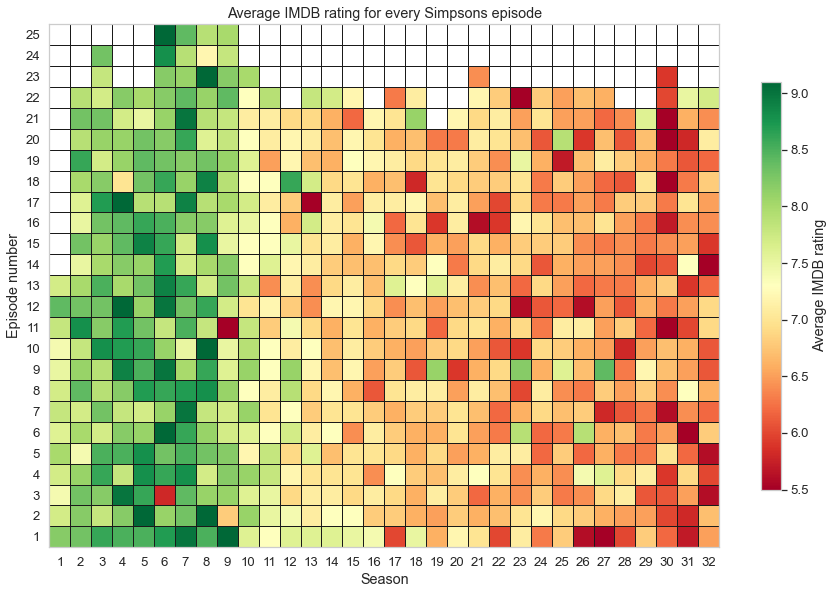

In [93]:
plot_color_square('averageRating','Average IMDB rating')

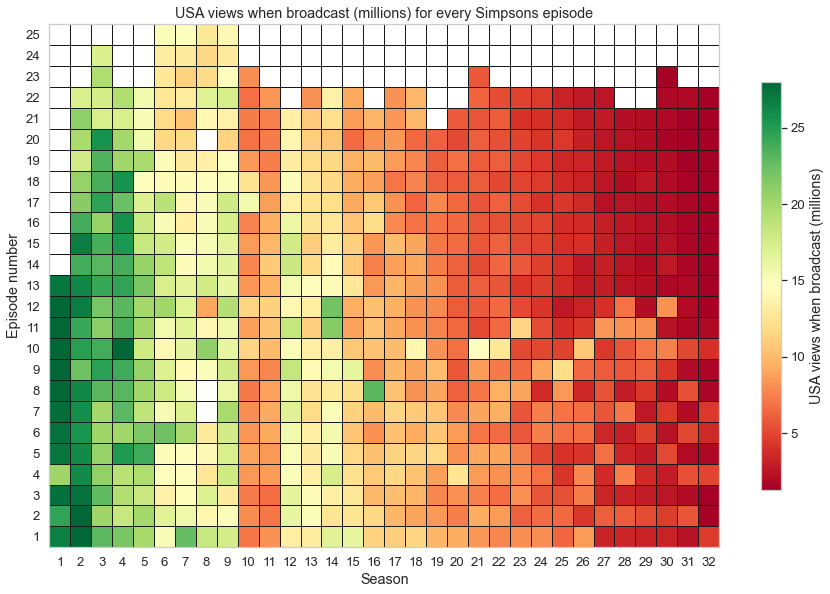

In [94]:
plot_color_square('US_viewers_millions', 'USA views when broadcast (millions)')

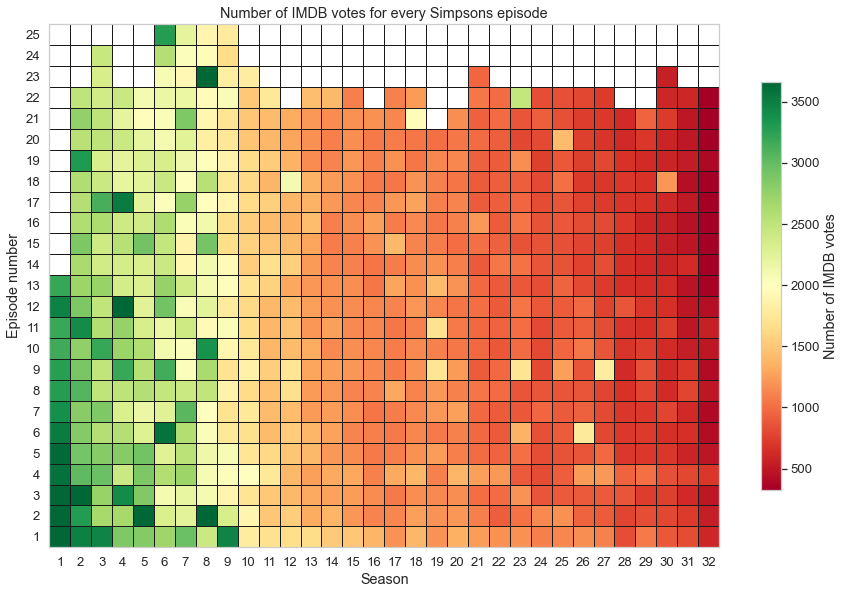

In [95]:
plot_color_square('numVotes', 'Number of IMDB votes')

In [86]:
def plot_line_quantiles(column,label=None):
    if label is None:
        label = column
    plt.figure(figsize=(12,8))
    sns.set_theme(style='whitegrid',font_scale=1.2)

    avgs = simpsons_df.groupby('seasonNumber').mean()
    stds = simpsons_df.groupby('seasonNumber').std()
    quant = lambda x: simpsons_df.groupby('seasonNumber').quantile(x)

    plt.plot(np.arange(0,32),avgs[column],linewidth=4)
    for i in np.arange(1.5,5.5):
        plt.fill_between(np.arange(0,32),quant(1-i/10)[column],quant(i/10)[column],alpha=0.07,color='blue')

    # plt.plot(np.arange(0,32),avgs['US_viewers_millions'],linewidth=4)
    # plt.fill_between(np.arange(0,32),avgs['US_viewers_millions']-stds['US_viewers_millions'],avgs['US_viewers_millions']+stds['US_viewers_millions'],alpha=0.2)

    plt.grid(b=True,alpha=0.3)
    ax = plt.gca()
    ax.set_xticks(np.arange(0,32))
    ax.set_xticklabels(range(1,33))
    plt.xlim([0,31])
    plt.xlabel('Season')
    plt.ylabel(label)
    plt.title(label+' for every season of The Simpsons')
    
    plt.show()

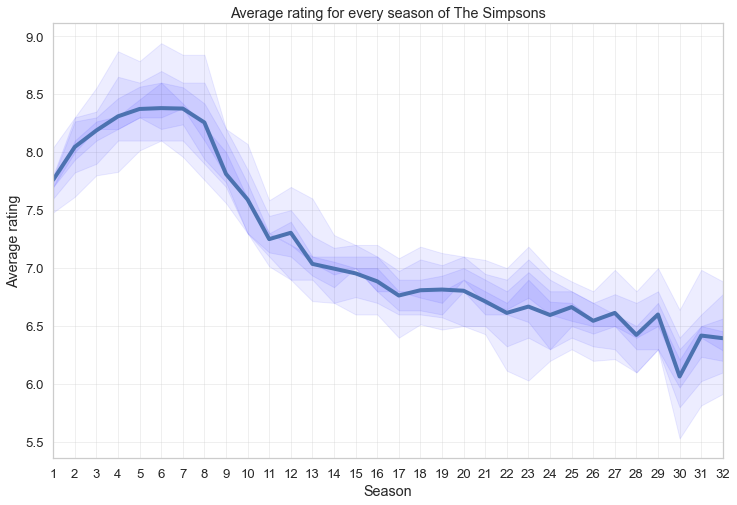

In [87]:
plot_line_quantiles('averageRating', 'Average rating')

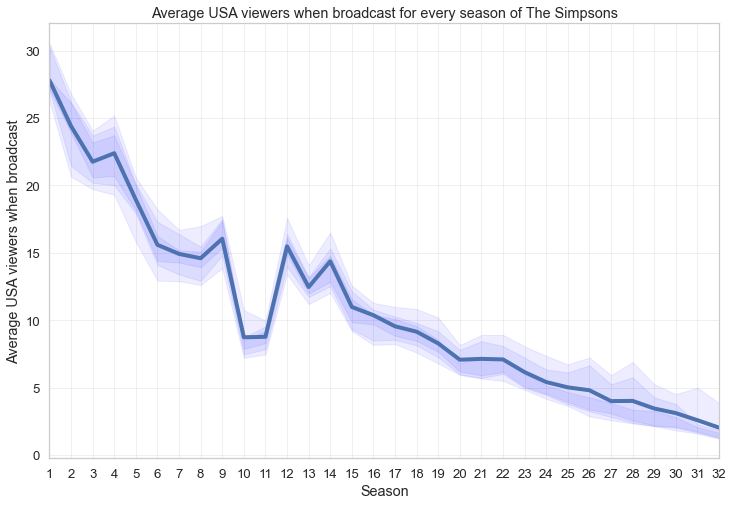

In [83]:
plot_line_quantiles('US_viewers_millions', 'Average USA viewers when broadcast')

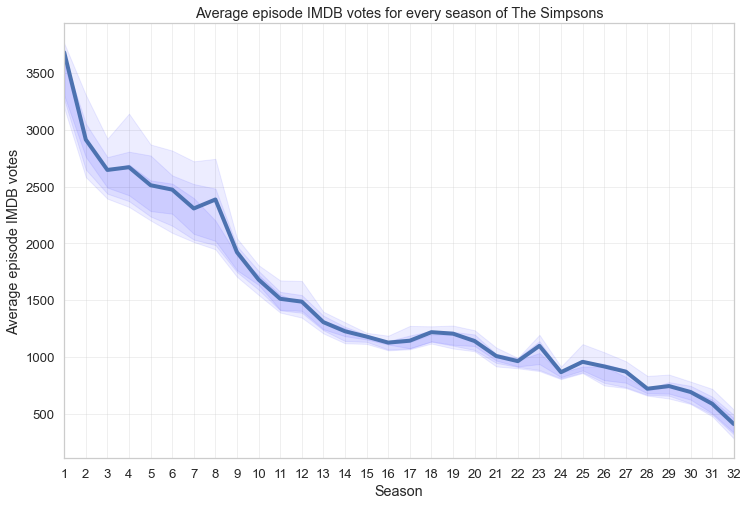

In [85]:
plot_line_quantiles('numVotes', 'Average episode IMDB votes')